In [1]:
import os
import copy
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import ImageFile
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import GlobalMaxPooling2D,Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

In [2]:
# fix error with truncated image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
train_df = pd.read_csv('/home/jupyter-chima/data/correa/train_censored.csv')
validate_df = pd.read_csv('/home/jupyter-chima/data/correa/val_censored.csv')
test_df = pd.read_csv('/home/jupyter-chima/data/correa/test_censored.csv')

In [4]:
train_df = train_df[train_df.Race.isin(['BLACK/AFRICAN AMERICAN','WHITE'])]
validate_df = validate_df[validate_df.Race.isin(['BLACK/AFRICAN AMERICAN','WHITE'])]
test_df = test_df[test_df.Race.isin(['BLACK/AFRICAN AMERICAN','WHITE'])]

In [5]:
train_df.hiti_path = train_df.hiti_path.astype(str)
validate_df.hiti_path = validate_df.hiti_path.astype(str)
test_df.hiti_path = test_df.hiti_path.astype(str)

In [6]:
#remove 0 byte images
train_df = train_df[~train_df.hiti_path.str.contains('406e0996e5f1cf082487d7d096574d10b46c0c52710222a4884db1cc|dd97e997cc2a4166dc6e192cb62e29553aa28f4671d98c9577e32cfd|6224290209c45bb2b3e07b3b3a27778d1d10f7953567b3c59158e099')]
validate_df = validate_df[~validate_df.hiti_path.str.contains('406e0996e5f1cf082487d7d096574d10b46c0c52710222a4884db1cc|dd97e997cc2a4166dc6e192cb62e29553aa28f4671d98c9577e32cfd|6224290209c45bb2b3e07b3b3a27778d1d10f7953567b3c59158e099')]
test_df = test_df[~test_df.hiti_path.str.contains('406e0996e5f1cf082487d7d096574d10b46c0c52710222a4884db1cc|dd97e997cc2a4166dc6e192cb62e29553aa28f4671d98c9577e32cfd|6224290209c45bb2b3e07b3b3a27778d1d10f7953567b3c59158e099')]

In [7]:
train_df.Race.value_counts()

WHITE                     91369
BLACK/AFRICAN AMERICAN    87139
Name: Race, dtype: int64

In [8]:
validate_df.Race.value_counts()

BLACK/AFRICAN AMERICAN    7540
WHITE                     6656
Name: Race, dtype: int64

In [9]:
test_df.Race.value_counts()

BLACK/AFRICAN AMERICAN    6067
WHITE                     5281
Name: Race, dtype: int64

In [10]:
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)
EPOCHS = 20
BATCH_SIZE = 256
learning_rate = 1e-3
decay_val= 0.0 
image_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [11]:
# setup train, valid, and test image data generators
train_gen = ImageDataGenerator(
            rotation_range=15, 
            fill_mode='constant',
            zoom_range=0.1,
            horizontal_flip=True,
)

validate_gen = ImageDataGenerator()

In [12]:
train_batches = train_gen.flow_from_dataframe(
    train_df, 
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=1,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

validate_batches = validate_gen.flow_from_dataframe(
    validate_df,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)        

Found 178508 validated image filenames belonging to 2 classes.
Found 14196 validated image filenames belonging to 2 classes.


In [13]:
# see the class names
class_names = train_df.Race.value_counts().index.tolist()
class_names.sort()
class_names

['BLACK/AFRICAN AMERICAN', 'WHITE']

In [14]:
# create model
n_labels = len(class_names)

base_model = EfficientNetB0( 
    input_shape=image_shape,
    include_top=False,
    weights='imagenet',
    drop_connect_rate=0.4
)

inputs = Input(image_shape)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(n_labels, name='dense_logits')(x)
output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
model = Model(inputs= inputs, outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_logits (Dense)         (None, 2)                 2562      
_________________________________________________________________
predictions (Activation)     (None, 2)                 0         
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [15]:
adam_opt = optimizers.Adam(lr=learning_rate, decay=decay_val)

model.compile(
    optimizer=adam_opt,
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.AUC(curve='ROC', name='ROC-AUC'),
        tf.keras.metrics.AUC(curve='PR', name='PR-AUC')
    ],
)

In [16]:
save = ModelCheckpoint(
    '/home/jupyter-chima/Bias/Emory_CXR/Binary_classes/EfficientNet/Checkpoint/', 
    monitor="val_PR-AUC", 
    save_best_only=True,
    save_weights_only=True, 
    mode='max',
    verbose=1
)
# stop = EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True)
scheduler = ReduceLROnPlateau(
    monitor="val_loss", 
    mode='min', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)
logger = CSVLogger('/home/jupyter-chima/Bias/Emory_CXR/Binary_classes/EfficientNet/training.log')
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validate_batches, 
    verbose=1, 
    callbacks=[save, scheduler, logger]
)

Epoch 1/20
698/698 [==============================] - ETA: 0s - loss: 0.2804 - ROC-AUC: 0.9521 - PR-AUC: 0.9521 
Epoch 00001: val_PR-AUC improved from -inf to 0.98290, saving model to /home/jupyter-chima/Bias/Emory_CXR/EfficientNet/Binary_classes/Checkpoint/
698/698 [==============================] - 27421s 39s/step - loss: 0.2804 - ROC-AUC: 0.9521 - PR-AUC: 0.9521 - val_loss: 0.1617 - val_ROC-AUC: 0.9835 - val_PR-AUC: 0.9829
Epoch 2/20
698/698 [==============================] - ETA: 0s - loss: 0.1993 - ROC-AUC: 0.9755 - PR-AUC: 0.9750 
Epoch 00002: val_PR-AUC did not improve from 0.98290
698/698 [==============================] - 29073s 42s/step - loss: 0.1993 - ROC-AUC: 0.9755 - PR-AUC: 0.9750 - val_loss: 0.2266 - val_ROC-AUC: 0.9722 - val_PR-AUC: 0.9708
Epoch 3/20
698/698 [==============================] - ETA: 0s - loss: 0.1754 - ROC-AUC: 0.9809 - PR-AUC: 0.9805 
Epoch 00003: val_PR-AUC improved from 0.98290 to 0.98321, saving model to /home/jupyter-chima/Bias/Emory_CXR/EfficientNe

In [17]:
model.save('/home/jupyter-chima/Bias/Emory_CXR/Binary_classes/EfficientNet/Emory_CXR_binary_classes_EfficientNet.h5')

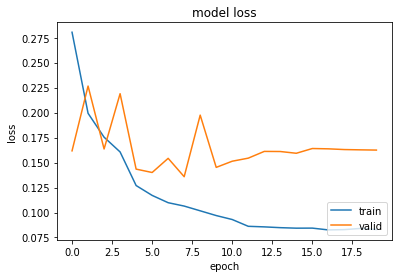

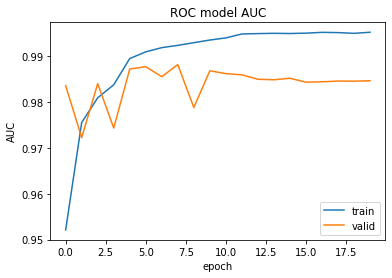

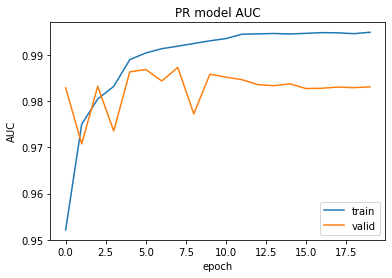

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
    
# summarize history for ROC auc
plt.plot(history.history['ROC-AUC'])
plt.plot(history.history['val_ROC-AUC'])
plt.title('ROC model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

# summarize history for ROC auc
plt.plot(history.history['PR-AUC'])
plt.plot(history.history['val_PR-AUC'])
plt.title('PR model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [19]:
test_batches=validate_gen.flow_from_dataframe(
    test_df,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

Found 11348 validated image filenames belonging to 2 classes.


In [20]:
predictions = model.predict(test_batches, len(test_batches.filenames)) 

In [21]:
y_hat = np.argmax(predictions, axis=1)
y_hat= list(y_hat)

In [22]:
# building the confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_batches.classes, y_hat))
print('Classification Report')
# batches are made in alphabetical order if shuffle is false
print(classification_report(test_batches.classes, y_hat, target_names=class_names,  zero_division = 0)) 

Confusion Matrix
[[5554  513]
 [ 112 5169]]
Classification Report
                        precision    recall  f1-score   support

BLACK/AFRICAN AMERICAN       0.98      0.92      0.95      6067
                 WHITE       0.91      0.98      0.94      5281

              accuracy                           0.94     11348
             macro avg       0.94      0.95      0.94     11348
          weighted avg       0.95      0.94      0.94     11348

